

# 트랜스포머 네트워크 모듈 목룍
1. 멀티헤드 어텐션 (Multi-head attention)
2. 서브시퀀트 마스크 어텐션 (Subsequent masked attention)
3. 포지션-와이드 피드 포워드 네트워크 (Position-wise feed fowrd network)
4. 리지듀얼 커넥션(Residual connection)


***

# 모듈 불러오기

In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [5]:
# 인코더의 입력 (즉, question)
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))

# 디코더의 입력 (즉, answer)
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))

# 디코더의 타겟 (즉, answer)
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))

# word2idx, idx2word, vocab_size, 기호 인덱스(pad, std, end, unk)
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [21]:
print(index_inputs[0]) # 인코더의 입력
print(index_outputs[0]) # 디코더의 입력
print(index_targets[0]) # 디코더의 타겟
print(len(index_inputs), index_inputs.shape )
print(len(index_outputs), index_outputs.shape)
print(len(index_targets), index_targets.shape)

[ 7237 19975     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[    1  1092  6458  5726 17918     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[ 1092  6458  5726 17918     2     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
11823 (11823, 25)
11823 (11823, 25)
11823 (11823, 25)


# 모델 하이퍼파라미터 정의

In [24]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']
model_name = "transformer"
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 3 #30
VALID_SPLIT = 0.1

kargs = {
    'model_name': model_name,
    'num_layers': 2,
    'd_model': 512, # key, query, value의 차원
    'num_heads': 8, # 어텐션 헤드 수
    'dff': 2048, # position-wise FFN 차원 수
    'input_vocab_size': vocab_size,
    'target_vocab_size': vocab_size,
    'maximum_position_encoding': MAX_SEQUENCE, # 25
    'end_token_idx': char2idx[end_index],
    'rate':0.1
}

# 모델 선언 및 컴파일

## 1) 패딩 및 포워드 마스킹 

In [132]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    # 남은 차원을 0으로 채움
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)



In [133]:
# 순방향으로 어텐션 맵을 마스킹한다.
# 순방햐 어텐션 시 (즉 순서가있는 단어에 대한 관계) 사용하는 순방향 마스크
def create_look_ahead_mask(size):
    # 마스킹할 영역은 1, 아닌 영역은 0으로 만든다.
    # 즉, 아래쪽 삼각형이 0이 되는 하삼각행렬을 만듬
    
    # tf.ones 로 모든 값이 1인 행렬 만듬
    # 그 다음 아래쪽 삼각형을 0으로 채움
    # (input, 0, -1) ==> Upper triangular part.
    # (input, -1, 0) ==> Lower triangular part. 즉, 우리는 아래쪽을 0으로 채울거라서 이거 사용
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # 입력행렬, -1, 0
    return mask # (seq_len, seq_len)
    

In [134]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [135]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)


## 2) 포지셔널 인코딩

In [136]:
# 각 순서에 따른 sin, cos 함수 각도값 얻기
# pos: 포지션에 대한 인덱스 위치 리스트
# i: 차원에 대한 리스트
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*i//2) / np.float32(d_model))
    return pos * angle_rates
    
    

In [137]:
# 포지션 임베딩 만들기
def positional_encoding(position, d_model): # 25, 512
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    print(np.arange(position)[:, np.newaxis].shape)
    print(np.arange(d_model)[np.newaxis, :].shape)
    print(angle_rads.shape)
    
    # 짝수 => sin
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # 홀수 => cos
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    print(pos_encoding.shape)
#     print(type(pos_encoding))

    # (배치차원, 시퀀스차원, 피처차원)
    return tf.cast(pos_encoding, dtype=tf.float32) # 넘파이를 텐서로 바꿈
    
    
    
    

(50, 1)
(1, 512)
(50, 512)
(1, 50, 512)


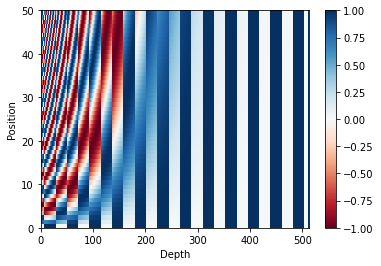

In [138]:
pos_encoding = positional_encoding(50, 512)
# print(type(pos_encoding))
# print(pos_encoding)


plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 이 차트 보면.. 
# depth 깊어질수록 임베딩 뒤차원의 값은 거의 0..
# position은 뒤로 갈수록(커질수록) 값이 depth 앞차원쪽에 몰려있음. (뒤차원 0값이 늘어남)
# 그리고 depth 커질수록 임베딩값 커졌다 작아졌다 하는걸 보니깐 짝수, 홀수에 대한 값 같음


In [139]:
print(pos_encoding.shape)
print(pos_encoding[0, 40]) 

(1, 50, 512)
tf.Tensor(
[ 0.74511313 -0.01696658  0.77540296  0.98017985 -0.4584321   0.41773638
 -0.97571594 -0.75848997 -0.08096503 -0.85950977  0.9098894   0.16715014
  0.72961646  0.97059757 -0.31582433  0.64047223 -0.98867553 -0.37475243
 -0.614248   -0.98942447  0.35331333 -0.65338385  0.97517693  0.25396407
  0.74632543  0.9288744  -0.07532834  0.86676145 -0.81969917  0.17801827
 -0.97031087 -0.6131116  -0.4816219  -0.9948548   0.28823665 -0.7780549
  0.8719563  -0.13799322  0.9741002   0.554764    0.58845377  0.9605351
 -0.05916608  0.9233052  -0.66180307  0.50070816 -0.9786478  -0.10452747
 -0.91676193 -0.65306264 -0.53441375 -0.96277225  0.011204   -0.95794374
  0.53617764 -0.6705424   0.8916597  -0.20785695  0.99892426  0.29322684
  0.85547256  0.70800424  0.5193704   0.95161617  0.08264565  0.9898257
 -0.35625705  0.835475   -0.714187    0.5358223  -0.9361187   0.15628901
 -0.9991225  -0.23496167 -0.9093901  -0.5788873  -0.6949922  -0.83278114
 -0.39695632 -0.9730023  -0.06

## 3) 어텐션

In [191]:
# qurey, key, value가 각각 단어벡터가 모인 행렬로 들어옴
def scaled_dot_product_attention(q, k, v, mask):
    # query와 key 내적
    matmul_qk = tf.matmul(q, k, transpose_b=True)   # (..., seq_len_q, seq_len_k) 
    
    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32) # k의 차원
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 마스크
    if mask is not None:
        # 마스킹된 부분(1) * -10^9 하면 10^9 값을 빼줄 수 있게 됨 
        # => 마스킹 된 부분의 어텐션 점수가 매우 작아짐 (매우 작은 음수값 가짐)
        # => softmax 취하면 거의 0에 수렴함
        scaled_attention_logits += (mask * -1e9)
        
    # softmax 취해서 어텐션 점수 구하기
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1)   # (..., seq_len_q, seq_len_k)
    
    # 어텐션 점수와 value 가중합 구하기
    output = tf.matmul(attention_weights, v) # (..., seq_len_q, depth_v)
    
    # 문맥 벡터, 어텐션 점수 리턴
    return output, attention_weights 
    
    

## 4) 멀티헤드 어텐션

In [192]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        # 어텐션 헤드 수
        self.num_heads = kargs['num_heads'] # 여기서는 8개
        
        # key, query, value에 대한 차원을 정의하기 위한 파라미터
        # => 어텐션 헤드 수만큼 나눠지는 것!
        self.d_model = kargs['d_model'] # 512 
        
        # 따라서 d_model // num_heads 했을때 나머지가 발생하면 안된다.
        # assert는 값이 false이면 에러 발생시킴. 즉 나머지 발생 시 에러남
        assert self.d_model % self.num_heads == 0
        
        # 나머지가 0이면, 그 나눈 값을 depth에 저장함
        # depth는 각 헤드에 입력될 벡터의 차원 수이다. (512//8=64)
        self.depth = self.d_model // self.num_heads
        
        # key, query, value에 대한 차원 수를 맞추기 위함
        # 스케일 내적 어텐션 연산 이전에 있는 Linear
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])
        
        # 셀프 어텐션 마지막 출력 레이어
        self.dense = tf.keras.layers.Dense(kargs['d_model'])
        
    
    # 각 key, query, value에 대한 벡터를 어텐션 헤드 수만큼 분리하는 함수
    # (배치차원, 시퀀스차원, 피처차원) => (배치차원, 헤드차원, 시퀀스차원, 피처차원)
    def split_heads(self, x, batch_size):
        
        # num_heads, depth : 하이퍼 파리미터 (이미 정해짐)
        # 시퀀스크기 : 학습하는 도중 배치 데이터의 시퀀스 길이가 매번 바뀔 수도 있음 
        # => 따라서 시퀀스 길이는 -1 로 정하고, batch_size값을 알아야하므로 인자로 정의하게 됨
        #       *** 참고) tf.reshape은 값을 하나만 모를 경우 가능 
        # (배치차원, 시퀀스차원, 헤드차원, 피처차원)으로 리턴
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        # (배치차원, 헤드차원, 시퀀스차원, 피처차원) 으로 바꿔줌
        return tf.transpose(x, perm=[0, 2, 1, 3]) 
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0] # batch_size
        
        q = self.wq(q) # (batch_size, seq_len, d_model=512)
        k = self.wq(k) # (batch_size, seq_len, d_model)
        v = self.wq(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth=d_model/num_heads=64)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
        
        # 내적 어텐션 적용 => 각 시퀀스마다 단어에 대한 context vector 구해짐 * 어텐션헤드 수
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 모든 어텐션 헤드 concat
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, 
                                     (batch_size, -1, self.d_model))
        
        # 마지막 dense 레이어로 출력 (멀티 헤드 어텐션 벡터 출력)
        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
        
        

## 5) 포인트 와이즈 피드포워드 네트워크 

In [193]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
        # (batch_size, seq_len, dff=2048)
        tf.keras.layers.Dense(kargs['dff'], activation='relu'),
        
        # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(kargs['d_model'])
    ])

## 인코더 레이어

In [194]:
# 여러개의 인코더 레이어를 쌓을 수 있도록 준비
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # 오버피팅 막고 모델 일반화를 위해 드롭아웃 적용
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, mask):
        
        # 1-1. 멀티 헤드 어텐션에 넣기
        # (batch_size, input_seq_len, d_model)
        # 셀프 어텐션을 하기 때문에 v, k, q가 모두 동일함
        attn_output, _ = self.mha(x, x, x, mask) # v, k, q, mask
        # 1-2. 드롭아웃
        attn_output = self.dropout1(attn_output)
        # 1-3. 리지듀얼 커넥션 + 층정규화
        out1 = self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)
        
        # 2-1. FFN
        # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)
        # 2-2. 드롭아웃
        ffn_output = self.dropout2(ffn_output)
        # 2-3. 리지듀얼 커넥션 + 층정규화
        out2 = self.layernorm2(out1 + ffn_output) 
        
        # (batch_size, input_seq_len, d_model)
        return out2
        
        
        

## 디코더 레이어

In [195]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)
        
        self.ffn = point_wise_feed_forward_network(**kargs)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
        
        
        
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # 디코더 입력, 인코더 출력(각 단어의 context vector), 순방향 마스크, 패딩 마스크
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        # 1) 디코더의 입력사이의 관계를 계산하는 셀프어텐션
        # (batch_size, target_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, # value
                                               x, # key 
                                               x, # query
                                               look_ahead_mask) # 순방향 마스크
        attn1 = self.dropout1(attn1) # 드롭아웃
        out1 = self.layernorm1(attn1 + x) # residual + 층 정규화
                                        # (batch_size, target_seq_len, d_model)
        
        # 2) 인코더의 결과값과 디코더의 셀프어텐션 결과값의 관계를 계산하는 어텐션
        attn2, attn_weights_block2 = self.mha2(enc_output, # vlaue
                                              enc_output, # key
                                              out1, # query
                                              padding_mask) # 패딩마스크 
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1) # (batch_size, target_seq_len, d_model)
        
        # 3) point-wise FFN
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2
    
    

## 인코더

In [196]:
# 전체적인 인코더 클래스
# 인코더 레이어, 워드 임베딩, 포지션 인코더 등으로 구성됨

class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()
        
        # 멀티헤드어텐션의 context vector 차원, 512
        # 각 헤드 차원은 512/8=64 임 (얘네 8개 concat 시켜서 최종 mha 출력 차원은 512)
        self.d_model = kargs['d_model'] 
        
        self.num_layers = kargs['num_layers'] # 인코더 레이어의 개수
        
        # 임베딩 레이어
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], # vocab size
                                                  self.d_model) # 출력차원
        
        # 포지션 인코딩
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], # 25
                                               self.d_model)
        
        # 인코더 레이어 x2
        self.enc_layers = [EncoderLayer(**kargs)
                          for _ in range(self.num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, mask):
        seq_len = tf.shape(x)[1] # 시퀀스 길이 (max는 25지만 각 시퀀스 길이는 다르다!)
        
        
        # 임베딩
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        
        # 루트 d_model 만큼 스케일링
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # 포지션 인코딩
        x += self.pos_encoding[:, :seq_len, :]
        
        # 드롭아웃
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
        
        # (batch_size, input_seq_len, d_model)
        return x
         
        
        
        



## 디코더

In [203]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()
        
        self.d_model = kargs['d_model'] # 512
        self.num_layers = kargs['num_layers'] # 512
        
        # 임베딩
        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'],
                                                  self.d_model) 
        # 포지션 인코딩
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], #25  
                                                self.d_model)
        
        # 디코더 레이어
        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        
        # 드롭아웃
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1] # 시퀀스 길이
        attention_weights = {}
        
        # 임베딩
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        
        # 스케일링
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # 포지션 인코딩 시퀀스 길이만큼 잘라주기
        x += self.pos_encoding[:, :seq_len, :]
        
        # 드롭아웃 적용
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, 
                                                   enc_output, 
                                                   look_ahead_mask,
                                                   padding_mask)
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
        
        
        

## 트렌스포머 모델

In [204]:
# 인코더와 디코더를 이어서 시퀀스 투 시퀀스 모델 형태로 구현한다.
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)
        
        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])
    
    # 학습을 위한 함수 (디코더 입력이 주어짐)
    def call(self, x):
        inp, tar = x # question, answer
        
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask) # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(tar,
                                    enc_output,
                                    look_ahead_mask,
                                    dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output
    
    # 추론을 위한 함수 (디코더 입력이 주어지지 않음. 매번 생성해야함)
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)
        
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        
        # 인코더에 넣음
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar,
                                        enc_output,
                                        look_ahead_mask,
                                        dec_padding_mask) # (batch_size, tar_seq_len, d_model)
            final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
            
            # 가장 큰 단어 가져옴
            outputs = tf.argmax(final_output, -1).numpy() 
            pred_token = outputs[0][-1]
            
            if pred_token == self.end_token_idx:
                break
            
            predict_tokens.append(pred_token)
            
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens
        
        
    
    
    
    

## 모델 로스 정의

In [205]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [206]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

(25, 1)
(1, 512)
(25, 512)
(1, 25, 512)
(25, 1)
(1, 512)
(25, 512)
(1, 25, 512)


# Callback 선언

In [207]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder already exists 



# 모델 학습

In [208]:
history = model.fit([index_inputs, index_outputs],
                    index_targets,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])
                    

Epoch 1/3


AttributeError: in user code:

    /Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-185-65b92d2ffab2>:20 call  *
        dec_output, _ = self.decoder(tar,
    <ipython-input-197-0e1bd2f9abc8>:39 call  *
        x, block1, block2 = self.dec_layers[i](x,
    <ipython-input-195-1e6198ca3227>:44 call  *
        ffn_output = self.dropout(ffn_output)

    AttributeError: 'DecoderLayer' object has no attribute 'dropout'
